In [204]:
#pip install --upgrade pandas-datareader


In [178]:
#pip install yfinance --upgrade --no-cache-dir

In [179]:
# Stock price prediction using an Artificial Neural Network called Long Short Term Mermory (LSTM).
import math
#import yfinance
import pandas_datareader as web
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM 
import plotly.graph_objects as go 
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


In [180]:
# Choose the stock ticker and the date at which the stock price is to be predicted.
stock_ticker = 'GOOGL'
quote_date = '2022-04-14'
# Choose the start and the end date
start = '2012-01-01'
end = '2022-04-13'


In [181]:
df = web.DataReader(stock_ticker, data_source='yahoo', start = start, end=end)

In [203]:
df['diff'] = df['Close'] - df['Open']
df.loc[df['diff'] >= 0, 'color'] = 'green'
df.loc[df['diff'] < 0, 'color'] = 'red'
fig = go.Figure(data = go.Scatter(x=df.index,y = df['Close']))
#fig.show()
fig2 = make_subplots(specs = [[{'secondary_y':True}]])
#fig2.add_trace(go.Scatter(x = df.index, y = df['Close'], name = 'Price'), secondary_y = False)
fig2.add_trace(go.Candlestick(x=df.index,
                              open = df['Open'],
                              high = df['High'],
                              low = df['Low'],
                              close = df['Close'],name = 'Price'))
fig2.add_trace(go.Bar(x = df.index, y = df['Volume'], name = 'Volume', marker = {'color':df['color']}), secondary_y = True)
fig2.update_layout(xaxis_rangeslider_visible=False)
fig2.update_yaxes(range=[0,1*max(df['Volume'])],secondary_y = True)
fig2.update_yaxes(visible = False, secondary_y = True)
#fig2.add_trace(go.Scatter(x = df.index, y = df['Close'].rolling(10).mean(), name = '10D-MA'))
fig2.update_layout(title = {'text':stock_ticker,'x':0.5})
fig2.show()

In [183]:
data = df.filter(['Close'])
dataset = data.values 
training_data_len = math.ceil(len(data)*0.8)

In [184]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [185]:
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []
for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])
  

In [186]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

In [187]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [188]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [189]:
model.fit(x_train, y_train, batch_size = 1, epochs = 1)

2011/2011 [==============================] - 80s 38ms/step - loss: 4.4385e-04


In [190]:
test_data = scaled_data[training_data_len - 60:,:]
x_test = []
y_test = dataset[training_data_len:,:]
for i in range(60,len(test_data)):
  x_test.append(test_data[i-60:i,0])

In [191]:
x_test = np.array(x_test)


In [192]:
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [193]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [194]:
rmse = np.sqrt((mean_squared_error(y_test, predictions)) )
rmse

66.9153197051277

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



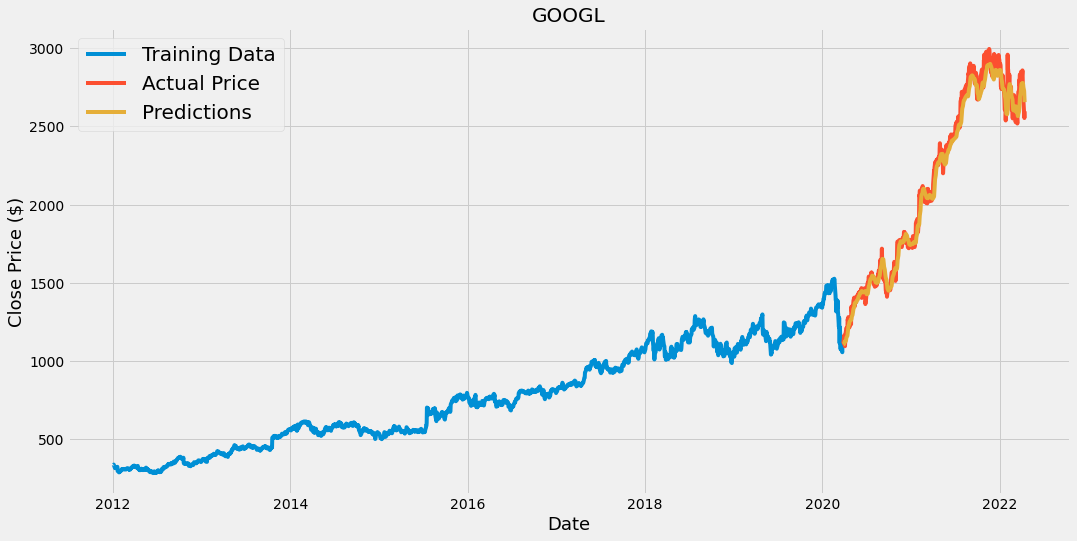

In [195]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price ($)', fontsize=18)
plt.title(stock_ticker, fontsize=20)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Training Data','Actual Price','Predictions'], fontsize=20,loc = 'upper left')
plt.show()

In [196]:
stock_quote = web.DataReader(stock_ticker, data_source='yahoo', start = start, end = end)
new_df = stock_quote.filter(['Close'])
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)
X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_price = model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price)
print(predicted_price)

[[2625.62]]


In [197]:
stock_quote2 = web.DataReader(stock_ticker, data_source='yahoo', start = quote_date, end = quote_date)
stock_quote2['Close']

Date
2022-04-14    2546
Name: Close, dtype: int64